<a href="https://colab.research.google.com/github/galitneu/auto-eda-tool/blob/main/%D7%95%D7%A9%D7%90%D7%A8%D7%99%D7%95%D7%AA_%D7%97%D7%99%D7%A9%D7%95%D7%91_%D7%A2%D7%9D_%D7%90%D7%99%D7%A0%D7%A4%D7%9C%D7%A6%D7%99%D7%94_%D7%A2%D7%95%D7%A0%D7%AA%D7%99%D7%95%D7%AA_2_%D7%9E%D7%95%D7%93%D7%9C%D7%99%D7%9D_%D7%A9%D7%9C_%D7%A8%D7%92%D7%A8%D7%A1%D7%99%D7%94_9096.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- שלב 0: ייבוא כל הספריות הנדרשות ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from google.colab import drive

# --- שלב 1: הגדרות וטעינת נתונים ---
print("--- שלב 1: טוען נתונים ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/KaggleProject/'

try:
    df_train_raw = pd.read_csv(f'{DRIVE_PATH}Train.csv', low_memory=False, parse_dates=['saledate'])
    df_valid_raw = pd.read_csv(f'{DRIVE_PATH}Valid.csv', low_memory=False, parse_dates=['saledate'])
    print("נתונים נטענו בהצלחה.")
except FileNotFoundError:
    print(f"שגיאה: ודא שהקבצים 'Train.csv' ו-'Valid.csv' נמצאים בתיקייה: {DRIVE_PATH}")
    exit()

# --- שלב 2: עיבוד נתונים והנדסת מאפיינים ---
print("\n--- שלב 2: מבצע עיבוד נתונים והנדסת מאפיינים ---")

# 2.1 סינון, אינפלציה ומאפייני זמן
print("שלב 2.1: סינון, אינפלציה ומאפייני זמן...")
df_train_raw = df_train_raw[df_train_raw['saledate'].dt.year >= 2000].copy()
df_valid_raw = df_valid_raw[df_valid_raw['saledate'].dt.year >= 2000].copy()

cpi_data_real = {
    2000: 172.2, 2001: 177.1, 2002: 179.9, 2003: 184.0, 2004: 188.9, 2005: 195.3,
    2006: 201.6, 2007: 207.3, 2008: 215.3, 2009: 214.5, 2010: 218.1, 2011: 224.9, 2012: 229.6
}
ADJUSTMENT_YEAR = 2012
inflation_multiplier = {year: cpi_data_real[ADJUSTMENT_YEAR] / cpi for year, cpi in cpi_data_real.items()}
df_train_raw['SalePrice_adj'] = df_train_raw.apply(lambda row: row['SalePrice'] * inflation_multiplier.get(row['saledate'].year, 1), axis=1)
train_original_prices = df_train_raw[['SalePrice', 'SalePrice_adj']].copy()

df_train_raw['source'] = 'train'
df_valid_raw['source'] = 'valid'
df_combined_temp = pd.concat([df_train_raw.drop(['SalePrice', 'SalePrice_adj'], axis=1), df_valid_raw], ignore_index=True)

min_date = df_combined_temp['saledate'].min()
for df in [df_combined_temp]:
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['DayOfYear'] = df['saledate'].dt.dayofyear
    df['DaysFromStart'] = (df['saledate'] - min_date).dt.days

df_train_raw = df_combined_temp[df_combined_temp['source'] == 'train'].drop('source', axis=1).copy()
df_valid_raw = df_combined_temp[df_combined_temp['source'] == 'valid'].drop('source', axis=1).copy()
df_train_raw = pd.concat([df_train_raw.reset_index(drop=True), train_original_prices.reset_index(drop=True)], axis=1)

# 2.2 חישוב מגמה ושאריות עם שני מודלים עונתיים
print("שלב 2.2: חישוב מגמה ושאריות עם שני מודלים עונתיים...")
# פיצול נתוני האימון לשתי עונות
early_season_train_df = df_train_raw[df_train_raw['saleMonth'].isin([1, 2, 3, 4])].copy()
rest_of_year_train_df = df_train_raw[~df_train_raw['saleMonth'].isin([1, 2, 3, 4])].copy()

# אימון שני מודלי מגמה נפרדים
trend_model_early = LinearRegression()
trend_model_early.fit(early_season_train_df[['DaysFromStart']], early_season_train_df['SalePrice_adj'])
trend_model_rest = LinearRegression()
trend_model_rest.fit(rest_of_year_train_df[['DaysFromStart']], rest_of_year_train_df['SalePrice_adj'])

# פונקציית עזר שמחילה את המודל הנכון לפי החודש
def predict_seasonal_trend(df):
    early_mask = df['saleMonth'].isin([1, 2, 3, 4])
    predictions = pd.Series(index=df.index, dtype=float)
    if early_mask.sum() > 0:
        predictions[early_mask] = trend_model_early.predict(df.loc[early_mask, ['DaysFromStart']])
    if (~early_mask).sum() > 0:
        predictions[~early_mask] = trend_model_rest.predict(df.loc[~early_mask, ['DaysFromStart']])
    return predictions

df_train_raw['SalePrice_Trend'] = predict_seasonal_trend(df_train_raw)
df_valid_raw['SalePrice_Trend'] = predict_seasonal_trend(df_valid_raw)
df_train_raw['SalePrice_Residual'] = df_train_raw['SalePrice_adj'] - df_train_raw['SalePrice_Trend']

# 2.3 איחוד לעיבוד סופי
train_labels_residual = df_train_raw['SalePrice_Residual'].copy()
df_train_proc = df_train_raw.drop(['SalePrice', 'SalePrice_adj', 'SalePrice_Trend', 'SalePrice_Residual', 'saledate', 'SalesID', 'MachineID'], axis=1)
df_train_proc['source'] = 'train'
df_valid_proc = df_valid_raw.drop(['SalePrice_Trend', 'saledate', 'SalesID', 'MachineID'], axis=1)
df_valid_proc['source'] = 'valid'
df_combined = pd.concat([df_train_proc, df_valid_proc], ignore_index=True, sort=False)

# 2.4 הנדסת מאפיינים ועיבוד נתונים מאוחד
print("שלב 2.4: הנדסת מאפיינים ועיבוד נתונים...")
# תיקון חכם ל-YearMade
year_made_by_model = df_combined.groupby('fiModelDesc')['YearMade'].median().astype(int)
rows_to_fix_idx = df_combined[df_combined['YearMade'] == 1000].index
imputed_years = df_combined.loc[rows_to_fix_idx, 'fiModelDesc'].map(year_made_by_model)
global_median_year = df_combined.loc[df_combined['YearMade'] != 1000, 'YearMade'].median()
imputed_years = imputed_years.fillna(global_median_year)
df_combined.loc[rows_to_fix_idx, 'YearMade'] = imputed_years.values
df_combined['machineAge'] = df_combined['saleYear'] - df_combined['YearMade']



# תיקון חכם ל-MachineHoursCurrentMeter
df_combined['MachineHoursCurrentMeter_is_missing'] = df_combined['MachineHoursCurrentMeter'].isnull() | (df_combined['MachineHoursCurrentMeter'] == 0)
df_combined['MachineHoursCurrentMeter'].replace(0, np.nan, inplace=True)
imputed_hours = df_combined.groupby('fiModelDesc')['MachineHoursCurrentMeter'].transform(lambda x: x.fillna(x.median()))
df_combined['MachineHoursCurrentMeter'] = imputed_hours
if df_combined['MachineHoursCurrentMeter'].isnull().sum() > 0:
    df_combined['MachineHoursCurrentMeter'].fillna(df_combined['MachineHoursCurrentMeter'].median(), inplace=True)

# טיפול בשאר הערכים החסרים והמרת קטגוריות
if df_combined['auctioneerID'].isnull().sum() > 0:
    df_combined['auctioneerID_is_missing'] = df_combined['auctioneerID'].isnull()
    df_combined['auctioneerID'] = df_combined['auctioneerID'].fillna(df_combined['auctioneerID'].median())

source_col = df_combined['source']
df_combined = df_combined.drop('source', axis=1)
for col_name in df_combined.columns:
    if pd.api.types.is_object_dtype(df_combined[col_name]):
        df_combined[col_name] = df_combined[col_name].fillna('missing').astype('category').cat.codes
df_combined['source'] = source_col

# --- שלב 3: הערכת ביצועים על סט וולידציה עונתי ---
print("\n" + "="*50)
print("--- שלב 3: הערכת ביצועים על סט וולידציה עונתי (ינואר-אפריל 2011) ---")

# 3.1 הכנת הנתונים לפיצול
df_train_processed = df_combined[df_combined['source'] == 'train'].drop('source', axis=1).copy()
df_train_processed['SalePrice_Residual'] = train_labels_residual.values
df_train_processed['SalePrice_adj'] = df_train_raw['SalePrice_adj'].values
df_train_processed['saledate'] = df_train_raw['saledate']

# 3.2 פיצול עונתי
train_time_split = df_train_processed[df_train_processed['saledate'] < '2011-01-01'].copy()
validation_mask = (df_train_processed['saledate'] >= '2011-01-01') & (df_train_processed['saledate'] < '2011-05-01')
val_time_split = df_train_processed[validation_mask].copy()

X_train_time = train_time_split.drop(['SalePrice_Residual', 'SalePrice_adj', 'saledate'], axis=1)
y_train_time_residual = train_time_split['SalePrice_Residual']
X_val_time = val_time_split.drop(['SalePrice_Residual', 'SalePrice_adj', 'saledate'], axis=1)
y_val_actual_price = val_time_split['SalePrice_adj']
val_time_trend = df_train_raw.loc[val_time_split.index, 'SalePrice_Trend'].values

X_val_time = X_val_time[X_train_time.columns]

# 3.3 אימון מודל וולידציה
print("\nמאמן מודל וולידציה (על נתוני 2000-2010)...")
user_params = {
    'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 3,
    'min_samples_leaf': 4, 'max_features': 0.5, 'n_jobs': -1, 'random_state': 42
}
validation_model = RandomForestRegressor(**user_params)
validation_model.fit(X_train_time, y_train_time_residual)

# 3.4 חיזוי וחישוב ציוני טעות
initial_val_preds_residual = validation_model.predict(X_val_time)
initial_val_preds_full_price = val_time_trend + initial_val_preds_residual

def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def rmsle(y_true, y_pred): return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 1)))

final_val_rmse = rmse(y_val_actual_price, initial_val_preds_full_price)
final_val_rmsle = rmsle(y_val_actual_price, initial_val_preds_full_price)

print("\n--- ביצועי המודל על סט הוולידציה העונתי ---")
print(f"סט וולידציה (Validation Set - ינואר-אפריל 2011):")
print(f"\tRMSE:  ${final_val_rmse:,.2f}")
print(f"\tRMSLE: {final_val_rmsle:.4f}\n")


# --- שלב 4: אימון מודל סופי עם הפרמטרים ---
print("\n" + "="*50)
print("--- שלב 4: מאמן מודל סופי עם הפרמטרים ---")

X_full_train = df_train_processed.drop(['SalePrice_Residual', 'SalePrice_adj', 'saledate'], axis=1)
y_full_train_residual = df_train_processed['SalePrice_Residual']

final_model = RandomForestRegressor(**user_params)
final_model.fit(X_full_train, y_full_train_residual)
print("אימון המודל הסופי הושלם!")

# --- שלב 5: יצירת קובץ הגשה סופי ---
print("\n--- שלב 5: יוצר קובץ הגשה סופי ---")
df_valid_processed = df_combined[df_combined['source'] == 'valid'].drop('source', axis=1).copy()
df_valid_processed_aligned = df_valid_processed[X_full_train.columns]

final_residuals_pred = final_model.predict(df_valid_processed_aligned)
final_trend_values = df_valid_raw['SalePrice_Trend'].values
final_price_pred = final_trend_values + final_residuals_pred
final_price_pred_floored = np.maximum(final_price_pred, 1000)

df_submission = pd.DataFrame({'SalesID': df_valid_raw['SalesID'], 'SalePrice': final_price_pred_floored})
submission_filename = f'{DRIVE_PATH}submission_Final_SeasonalTrend.csv'
df_submission.to_csv(submission_filename, index=False)

print(f"\nקובץ ההגשה '{submission_filename}' נשמר בהצלחה!")
print("5 השורות הראשונות בקובץ ההגשה:")
print(df_submission.head())

--- שלב 1: טוען נתונים ---
Mounted at /content/drive
נתונים נטענו בהצלחה.

--- שלב 2: מבצע עיבוד נתונים והנדסת מאפיינים ---
שלב 2.1: סינון, אינפלציה ומאפייני זמן...
שלב 2.2: חישוב מגמה ושאריות עם שני מודלים עונתיים...
שלב 2.4: הנדסת מאפיינים ועיבוד נתונים...


/tmp/ipython-input-1148561370.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['MachineHoursCurrentMeter'].replace(0, np.nan, inplace=True)
/tmp/ipython-input-1148561370.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v


--- שלב 3: הערכת ביצועים על סט וולידציה עונתי (ינואר-אפריל 2011) ---

מאמן מודל וולידציה (על נתוני 2000-2010)...

--- ביצועי המודל על סט הוולידציה העונתי ---
סט וולידציה (Validation Set - ינואר-אפריל 2011):
	RMSE:  $9,019.80
	RMSLE: 0.2267


--- שלב 4: מאמן מודל סופי עם הפרמטרים ---
אימון המודל הסופי הושלם!

--- שלב 5: יוצר קובץ הגשה סופי ---

קובץ ההגשה '/content/drive/MyDrive/KaggleProject/submission_Final_SeasonalTrend.csv' נשמר בהצלחה!
5 השורות הראשונות בקובץ ההגשה:
        SalesID     SalePrice
313947  1222837  59516.431872
313948  1222839  67674.577281
313949  1222841  33934.850919
313950  1222843  17321.283413
313951  1222845  44613.302541


In [ ]:
# --- ניתוח עונתי מעמיק: מה מיוחד בחודשים ינואר-אפריל? ---
print("\n" + "="*50)
print("--- מבצע ניתוח השוואתי בין 'תחילת העונה' ל'שאר השנה' ---")

# 1. פיצול הנתונים לשתי קבוצות עונתיות
# נשתמש ב-df_train_processed שכבר מכיל את כל הנתונים המעובדים
early_season_df = df_train_processed[df_train_processed['saleMonth'].isin([1, 2, 3, 4])].copy()
rest_of_year_df = df_train_processed[~df_train_processed['saleMonth'].isin([1, 2, 3, 4])].copy()

print(f"נמצאו {len(early_season_df)} רשומות בתחילת העונה ו-{len(rest_of_year_df)} רשומות בשאר השנה.\n")


# 2. השוואת הרכב המכירות (לפי ProductGroup)
print("--- השוואת הרכב המכירות (Top 5 ProductGroup) ---")
early_season_counts = early_season_df['ProductGroup'].value_counts(normalize=True)
rest_of_year_counts = rest_of_year_df['ProductGroup'].value_counts(normalize=True)

comparison_df = pd.DataFrame({
    'Early_Season_%': early_season_counts,
    'Rest_of_Year_%': rest_of_year_counts
}).fillna(0)
comparison_df['Difference'] = comparison_df['Early_Season_%'] - comparison_df['Rest_of_Year_%']
print(comparison_df.sort_values('Difference', ascending=False).head())


# 3. השוואת מאפיינים מספריים מרכזיים
print("\n\n--- השוואת מאפיינים מספריים (ממוצע) ---")
numeric_comparison = pd.DataFrame({
    'Early_Season_Mean': early_season_df[['SalePrice_adj', 'machineAge', 'MachineHoursCurrentMeter']].mean(),
    'Rest_of_Year_Mean': rest_of_year_df[['SalePrice_adj', 'machineAge', 'MachineHoursCurrentMeter']].mean()
})
numeric_comparison['Difference'] = numeric_comparison['Early_Season_Mean'] - numeric_comparison['Rest_of_Year_Mean']
print(numeric_comparison)


--- מבצע ניתוח השוואתי בין 'תחילת העונה' ל'שאר השנה' ---
נמצאו 113160 רשומות בתחילת העונה ו-200787 רשומות בשאר השנה.

--- השוואת הרכב המכירות (Top 5 ProductGroup) ---
              Early_Season_%  Rest_of_Year_%  Difference
ProductGroup                                            
3                   0.280629        0.261621    0.019009
4                   0.189740        0.185649    0.004091
5                   0.170369        0.168507    0.001862
1                   0.059420        0.059107    0.000313
2                   0.116667        0.126233   -0.009567


--- השוואת מאפיינים מספריים (ממוצע) ---
                          Early_Season_Mean  Rest_of_Year_Mean   Difference
SalePrice_adj                  36428.542741       34833.646364  1594.896377
machineAge                        41.612778          33.919283     7.693496
MachineHoursCurrentMeter        6694.660653        5662.314674  1032.345979



--- מתחיל ניתוח עונתי מתקדם ---

מפיק גרף 1: השוואת התפלגויות לפי קבוצת מוצר...


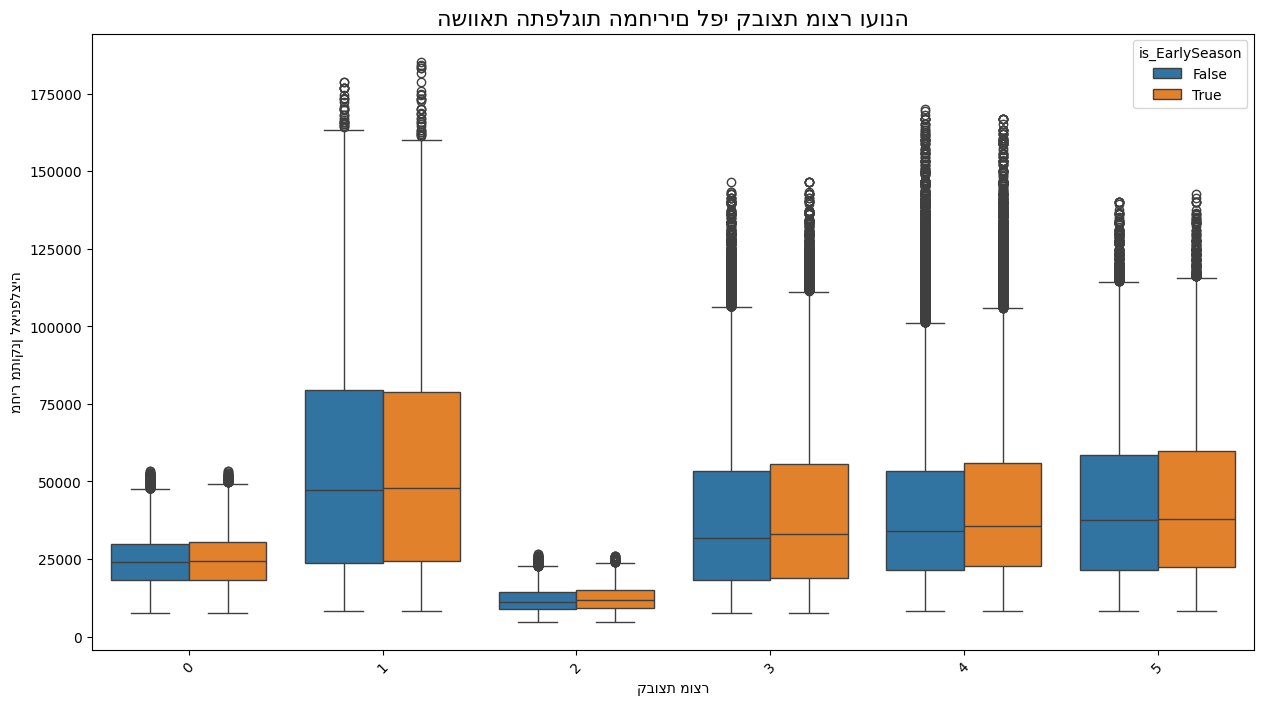


מפיק גרף 2: ניתוח הקשר בין גיל למחיר...


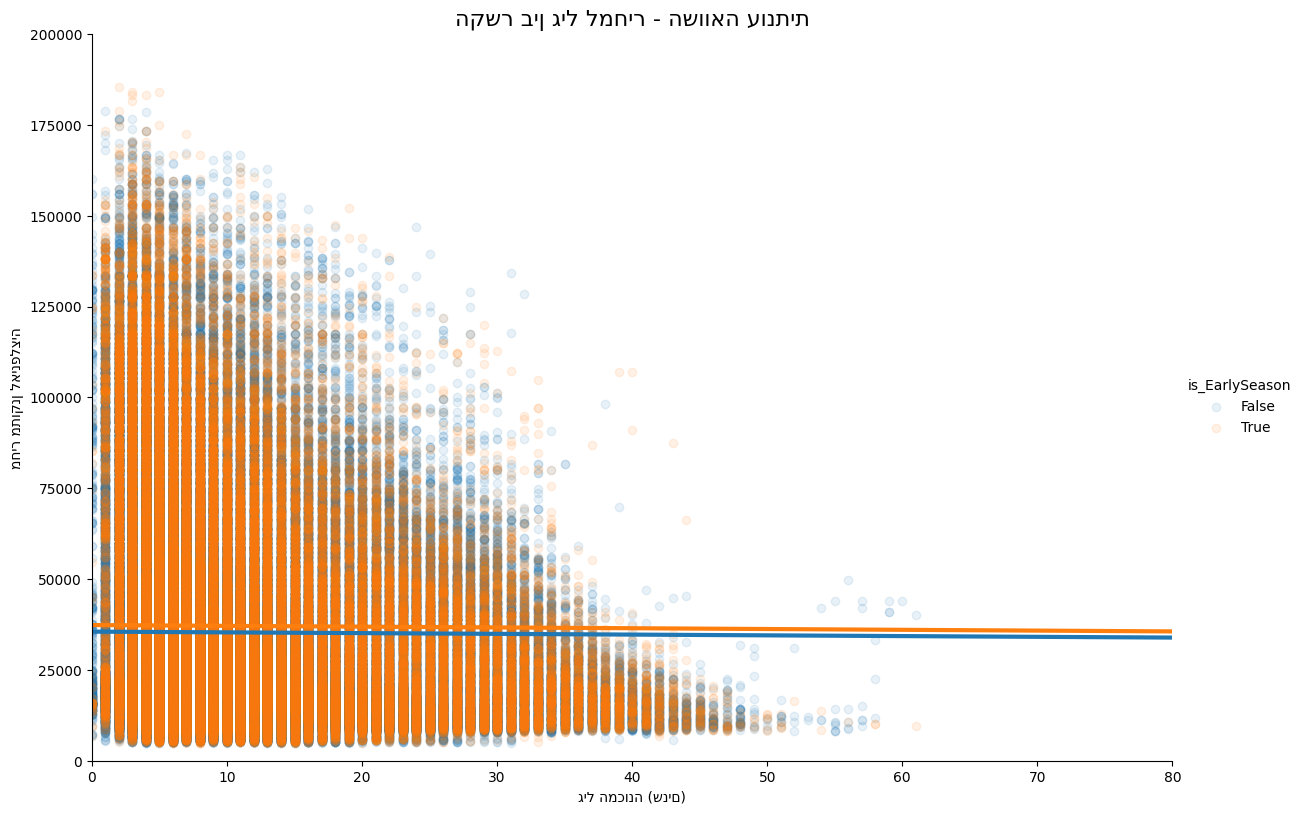


מפיק גרף 3: מפת חום של הפרשי קורלציות...


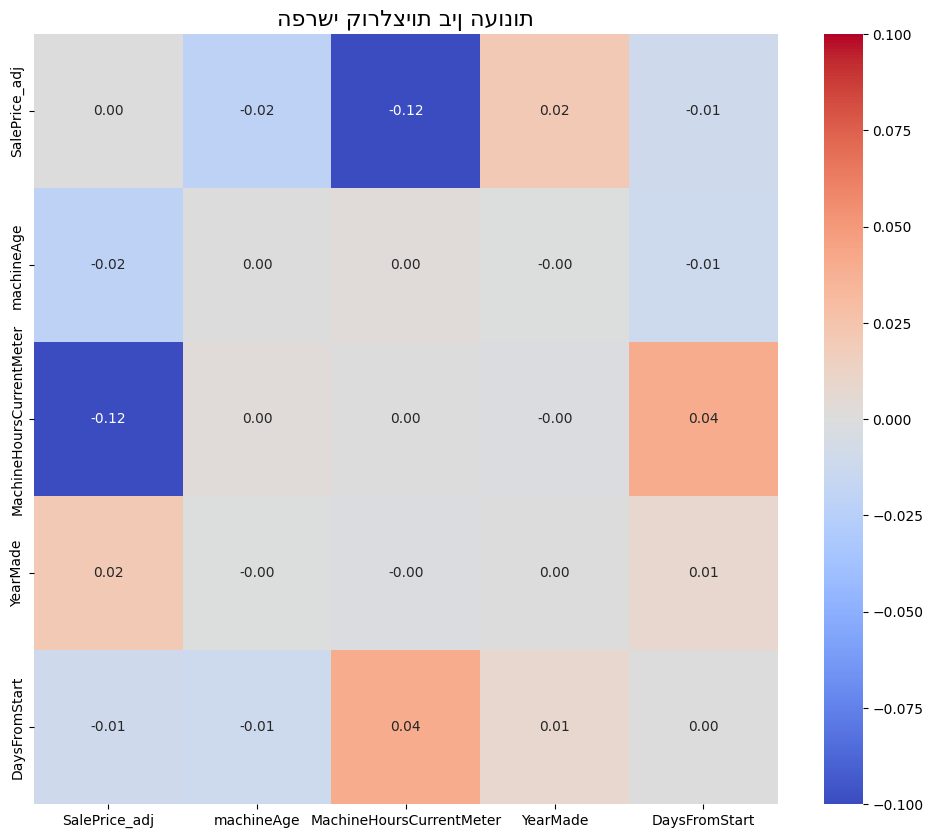


--- הניתוח הסתיים ---


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- ניתוח עונתי מתקדם ומאוחד ---
print("\n" + "="*50)
print("--- מתחיל ניתוח עונתי מתקדם ---")

# ודא שעמודת 'is_EarlySeason' קיימת ב-df_train_processed
if 'is_EarlySeason' not in df_train_processed.columns:
    df_train_processed['is_EarlySeason'] = df_train_processed['saleMonth'].isin([1, 2, 3, 4])


# --- 1. השוואת התפלגויות המחיר לפי קבוצת מוצר (Box Plots) ---
print("\nמפיק גרף 1: השוואת התפלגויות לפי קבוצת מוצר...")
plt.figure(figsize=(15, 8))
sns.boxplot(x='ProductGroup', y='SalePrice_adj', hue='is_EarlySeason', data=df_train_processed)
plt.title('השוואת התפלגות המחירים לפי קבוצת מוצר ועונה', fontsize=16)
plt.ylabel('מחיר מתוקנן לאינפלציה')
plt.xlabel('קבוצת מוצר')
plt.xticks(rotation=45)
plt.show()


# --- 2. ניתוח הקשר המשתנה בין גיל למחיר (Scatter Plot) ---
print("\nמפיק גרף 2: ניתוח הקשר בין גיל למחיר...")
# שימוש ב-lmplot שמצייר אוטומטית קווי מגמה
sns.lmplot(x='machineAge', y='SalePrice_adj', hue='is_EarlySeason', data=df_train_processed,
           height=8, aspect=1.5, scatter_kws={'alpha':0.1}, line_kws={'linewidth':3})
plt.title('הקשר בין גיל למחיר - השוואה עונתית', fontsize=16)
plt.xlabel('גיל המכונה (שנים)')
plt.ylabel('מחיר מתוקנן לאינפלציה')
plt.ylim(0, 200000) # הגבלת ציר ה-Y לצורך בהירות
plt.xlim(0, 80)     # הגבלת ציר ה-X לצורך בהירות
plt.show()


# --- 3. זיהוי שינויים במבנה הנתונים (מפת חום של קורלציות) ---
print("\nמפיק גרף 3: מפת חום של הפרשי קורלציות...")
# בחירת מספר מאפיינים מספריים חשובים
cols_for_corr = ['SalePrice_adj', 'machineAge', 'MachineHoursCurrentMeter', 'YearMade', 'DaysFromStart']

# יצירת תתי-קבוצות עונתיות
early_season_df = df_train_processed[df_train_processed['is_EarlySeason'] == True][cols_for_corr]
rest_of_year_df = df_train_processed[df_train_processed['is_EarlySeason'] == False][cols_for_corr]

# חישוב מטריצות קורלציה
corr_early = early_season_df.corr()
corr_rest = rest_of_year_df.corr()

# חישוב ההפרש
corr_diff = corr_early - corr_rest

# הצגת מפת החום של ההפרשים
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, cmap='coolwarm', fmt='.2f', vmin=-0.1, vmax=0.1)
plt.title('הפרשי קורלציות בין העונות', fontsize=16)
plt.show()

print("\n--- הניתוח הסתיים ---")